# Requirements

In [ ]:
! pip install tensorflow==2.15.0 keras-crf scikit-learn==1.2.2 gensim matplotlib

or

In [ ]:
! pip install -r requirements.txt

# Data loading

In [ ]:
import json
def get_data(path: str) -> dict:
    file = open(path,"r")
    data = json.load(file)
    file.close()
    return data

In [1]:
# ATE Dataset
data_train = get_data("ATE_train.json")
data_val   = get_data("ATE_val.json")
data_test  = get_data("ATE_test.json")
len(data_train)

906

In [1]:
# NER Dataset
data_train = get_data("NER_train_rev1.json")
data_val   = get_data("NER_val_rev1.json")
data_test  = get_data("NER_test_rev1.json")
len(data_train)

6839

## Data prep

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import numpy as np

def pad_and_encode_data(data:dict,maxlen:int,lenc:LabelEncoder=None):
    tokens = []
    labels = []
    isgiven = False
    if(lenc == None):
        l = LabelEncoder()
        isgiven = True
    else:
        l = lenc
    for i in data.keys():
        text_split = data[i]["text"].split(' ')
        labels_i   = data[i]["labels"]

        # we don't consider stale data e.g text_split = [''] and labels = []
        if (len(text_split) != len(labels_i)):
            continue

        tokens.append(text_split)
        labels.append(labels_i)
    
    tokens     = pad_sequences(sequences=tokens,maxlen=maxlen,dtype=object,padding="post",truncating="post",value="<pad>")
    raw_labels = pad_sequences(sequences=labels,maxlen=maxlen,dtype=object,padding="post",truncating="post",value="<pad>")
    labels = []

    if (isgiven):
        l.fit(np.unique(raw_labels))

    for i in raw_labels:
        labels.append(l.transform(i))
    del raw_labels
    
    return tokens, labels, l

In [ ]:
import pickle
f = open("ENCODING_NER.pkl","rb")
label_encoder = pickle.load(f)
f.close()

In [ ]:
import pickle
f = open("ENCODING_ATE.pkl","rb")
label_encoder = pickle.load(f)
f.close()

In [ ]:
train_x, train_y, _ = pad_and_encode_data(data_train,MAX_LEN,label_encoder)
val_x, val_y, _     = pad_and_encode_data(data_val,MAX_LEN,label_encoder)
text_x, text_y, _   = pad_and_encode_data(data_test,MAX_LEN,label_encoder)

# Essestial Classes 

In [3]:
import numpy as np
import gensim
import re


class Word2Vec:
    def __init__(self,path: str,pad: str):
        self.model = gensim.models.KeyedVectors.load(path)
        self.pad = pad

    def word2vec_preprocessing(self,token: str):
        j = token
        #UK to US conversion of some frequent characters
        g_change = {
            "offence" :"offense",
            "offences":"offenses",
            "favour"  :"favor",
            "defence" :"defense",
            "licence" :"license",
            "Honble"  :"Hon'ble"
        }
        #removing non compactible tokens and converting to suitable format
        for p  in '''(),[]<>/?!|=:;$\'%^_{}~%\"''':
            if len(j) == 1:
                j = '<pun>'
            else:
                j = j.replace(p,'')
            
        j = re.sub(r"\B\.\B",'',j)
        j = re.sub(r"\b\.\B",'',j)
        j = re.sub(r"[0-9]{4,}",'####',j)
        j = re.sub(r"[0-9]{3}" ,'###',j)
        j = re.sub(r"[0-9]{2}" ,'##',j)
        j = re.sub(r"[0-9]\."  ,'#.',j)

        if j in ['a','of','and','to']:
            j = '<red>'

        if j in g_change.keys():
            j = g_change[j]

        return j
    
    def encode(self,token: list) -> np.ndarray:
        tokens = token
        vec = []
        for  i in range(len(tokens)):
            tokens[i] = self.word2vec_preprocessing(tokens[i])

        for i in range(len(tokens)):
            try:
                vec.append(self.model.get_vector(tokens[i]))
            except KeyError:
                if (tokens[i] == self.pad):
                    vec.append(np.full((300),-1.0))
                elif (tokens[i] == "<red>"):
                    vec.append(np.full( (300),1.0))
                elif (tokens[i] == "<pun>"):
                    vec.append(np.full((300),-0.5))
                else:
                    vec.append(np.zeros(300))
        
        if(len(vec) != len(token)):
            print("check Embedding code tokens are missinng")
        return np.array(vec)

In [4]:
import numpy as np
import gensim
import re


class Glove:
    def __init__(self,path: str,pad: str):
        self.model = gensim.models.KeyedVectors.load(path)
        self.pad = pad

    def glove_preprocessing(self,token : str):
        j = token.casefold()
        #UK to US conversion of some frequent characters
        g_change = {
            "honble"  :"honorable"
        }
        j = token.casefold()
        for p  in '''/|=:;$%^_{}~%\'''':
            j = j.replace(p,'')
        j = re.sub(r"\B[\.\":;]\B",'',j)
        j = re.sub(r"\b[\.\":;]\B",'',j)
        j = re.sub(r"\B[\.\":;]\b",'',j)
        if j in g_change.keys():
            j = g_change[j]
        return j
    
    def encode(self,token: list):
        tokens = token
        vec = []
        for  i in range(len(tokens)):
            tokens[i] = self.glove_preprocessing(tokens[i])

        for i in range(len(tokens)):
            try:
                vec.append(self.model.get_vector(tokens[i]))
            except KeyError:
                if (tokens[i] == self.pad):
                    vec.append(np.full((300),-1.0))
                else:
                    vec.append(np.zeros(300))
        
        if(len(vec) != len(token)):
            print("check Embedding code tokens are missinng")
        return np.array(vec)

In [5]:
import numpy as np
import gensim
import re


class Fasttext:
    def __init__(self,path: str,pad: str):
        self.model = gensim.models.KeyedVectors.load(path)
        self.pad = pad

    def fs_preprocessing(self,token : str):
        j = token
        for p  in '''/|=:;$%^_{}~%\'''':
            j = j.replace(p,'')
        j = re.sub(r"\B[\.\":;]\B",'',j)
        j = re.sub(r"\b[\.\":;]\B",'',j)
        j = re.sub(r"\B[\.\":;]\b",'',j)
        return j
    
    def encode(self,token: list):
        tokens = token
        vec = []
        for  i in range(len(tokens)):
            tokens[i] = self.fs_preprocessing(tokens[i])

        for i in range(len(tokens)):
            try:
                vec.append(self.model.get_vector(tokens[i]))
            except KeyError:
                if (tokens[i] == self.pad):
                    vec.append(np.full((300),-1.0))
                else:
                    vec.append(np.zeros(300))
        
        if(len(vec) != len(token)):
            print("check Embedding code tokens are missinng")
        return np.array(vec)

In [6]:
def data_generator(X,y, batch_size):
    texts  = X
    labels = y
    while True:
        for i in range(0, len(texts), batch_size):
            batch_texts  = texts[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            yield batch_texts, np.array(batch_labels)

In [7]:
def data_generatorx(X, batch_size):
    texts = X
    while True:
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            yield (batch_texts,)

In [8]:
MAX_LEN = 100

In [15]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score

class F1ScoreCallbackTrain(Callback):
    def __init__(self,X_train,y_train,X_val,y_val,model_save_loc):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.model_save_loc = model_save_loc
        self.val_max = 0

    def on_epoch_end(self, epoch, logs=None):
        train_predict = self.model.predict(data_generatorx(self.X_train,32),steps=int(np.ceil(len(self.X_train) / 32)),verbose=0)[0]
        val_predict   = self.model.predict(data_generatorx(self.X_val,32),steps=int(np.ceil(len(self.X_val) / 32)),verbose=0)[0]

        train_f1 = f1_score(np.array(self.y_train).flatten(), train_predict.flatten(), average='macro')
        val_f1   = f1_score(np.array(self.y_val).flatten(), val_predict.flatten(), average='macro')

        logs['train_f1_score'] = train_f1
        logs['val_f1_score']   = val_f1

        if(val_f1 > self.val_max):
            self.model.save_weights(self.model_save_loc)
            self.val_max = val_f1
        

In [16]:
import matplotlib.pyplot as plt

def plot_metrics(history, task, model_type):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss {task} Dataset for {model_type}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['train_f1_score'], label='Training F1 Score')
    plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
    plt.title(f'Model F1 Score {task} Dataset for {model_type}')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Training with different embeddings


In [17]:
embedding = Word2Vec("models/word2vec-google-news-300.model","<pad>")

In [18]:
train_x_vec = np.array([embedding.encode(i) for i in train_x])
val_x_vec   = np.array([embedding.encode(i) for i in val_x])
test_x_vec  = np.array([embedding.encode(i) for i in text_x])

In [19]:
del embedding

In [ ]:
from keras_crf import CRFModel
from keras.layers import Input, Bidirectional,LSTM
from keras.models import Model

input = Input(shape=(MAX_LEN,300))
blstm = Bidirectional(LSTM(units=300, return_sequences=True))(input)
model = Model(input,blstm)
model = CRFModel(model,len(label_encoder.classes_))

model.compile(optimizer="adam", metrics=['accuracy'])

In [ ]:
f1_callback = F1ScoreCallbackTrain(train_x_vec, train_y, val_x_vec, val_y,"w2v-BLC-ATE.h5")

history = model.fit(data_generator(train_x_vec,train_y,32),
                        steps_per_epoch=len(train_x_vec) // 32,
                        epochs= 20,
                        validation_data=data_generator(val_x_vec,val_y,32),
                        validation_steps=len(val_x_vec) // 32,
                        callbacks=[f1_callback])
plot_metrics(history, 'NER-fs', 'Bi-LSTM-CRF')

In [11]:
embedding = Glove("models/glove-wiki-gigaword-300.model","<pad>")

In [12]:
train_x_vec = np.array([embedding.encode(i) for i in train_x])
val_x_vec   = np.array([embedding.encode(i) for i in val_x])
test_x_vec  = np.array([embedding.encode(i) for i in text_x])

In [13]:
del embedding

In [28]:
from keras_crf import CRFModel
from keras.layers import Input, Bidirectional,LSTM
from keras.models import Model

input = Input(shape=(MAX_LEN,300))
blstm = Bidirectional(LSTM(units=300, return_sequences=True))(input)
model = Model(input,blstm)
model = CRFModel(model,len(label_encoder.classes_))

model.compile(optimizer="adam", metrics=['accuracy'])

In [32]:
f1_callback = F1ScoreCallbackTrain(train_x_vec, train_y, val_x_vec, val_y,"gl-BLC-ATE.h5")

history = model.fit(data_generator(train_x_vec,train_y,32),
                        steps_per_epoch=len(train_x_vec) // 32,
                        epochs= 20,
                        validation_data=data_generator(val_x_vec,val_y,32),
                        validation_steps=len(val_x_vec) // 32,
                        callbacks=[f1_callback])
plot_metrics(history, 'NER-fs', 'Bi-LSTM-CRF')

Epoch 1/20


2024-03-13 19:05:14.746705: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_BOOL
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond/output/_21'


28/28 [==============================] - 16s 370ms/step - decode_sequence_accuracy: 0.9134 - loss: 21.8364 - val_decode_sequence_accuracy: 0.9636 - val_loss: 12.2379 - train_f1_score: 0.4768 - val_f1_score: 0.4824
Epoch 2/20
28/28 [==============================] - 9s 318ms/step - decode_sequence_accuracy: 0.9620 - loss: 10.4558 - val_decode_sequence_accuracy: 0.9639 - val_loss: 11.2095 - train_f1_score: 0.5613 - val_f1_score: 0.5629
Epoch 3/20
28/28 [==============================] - 10s 376ms/step - decode_sequence_accuracy: 0.9642 - loss: 9.2614 - val_decode_sequence_accuracy: 0.9673 - val_loss: 9.1554 - train_f1_score: 0.6364 - val_f1_score: 0.6237
Epoch 4/20
28/28 [==============================] - 10s 359ms/step - decode_sequence_accuracy: 0.9668 - loss: 8.4276 - val_decode_sequence_accuracy: 0.9695 - val_loss: 7.0668 - train_f1_score: 0.6710 - val_f1_score: 0.6578
Epoch 5/20
28/28 [==============================] - 10s 370ms/step - decode_sequence_accuracy: 0.9691 - loss: 7.7659

In [30]:
embedding = Fasttext("models/fasttext-wiki-news-subwords-300.model","<pad>")

In [31]:
train_x_vec = np.array([embedding.encode(i) for i in train_x])
val_x_vec   = np.array([embedding.encode(i) for i in val_x])
test_x_vec  = np.array([embedding.encode(i) for i in text_x])

In [32]:
del embedding

In [16]:
from keras_crf import CRFModel
from keras.layers import Input, Bidirectional,LSTM
from keras.models import Model

input = Input(shape=(MAX_LEN,300))
blstm = Bidirectional(LSTM(units=300, return_sequences=True))(input)
model = Model(input,blstm)
model = CRFModel(model,len(label_encoder.classes_))

model.compile(optimizer="adam", metrics=['accuracy'])

/home/mint/dev/NLP/sb/NLP_Assignment2/.venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Epoch 1/20


28/28 [==============================] - 17s 427ms/step - decode_sequence_accuracy: 0.8911 - loss: 32.5234 - val_decode_sequence_accuracy: 0.9587 - val_loss: 14.2015 - train_f1_score: 0.4724 - val_f1_score: 0.4731
Epoch 2/20
28/28 [==============================] - 10s 349ms/step - decode_sequence_accuracy: 0.9611 - loss: 11.9553 - val_decode_sequence_accuracy: 0.9627 - val_loss: 12.4235 - train_f1_score: 0.4724 - val_f1_score: 0.4731
Epoch 3/20
28/28 [==============================] - 10s 356ms/step - decode_sequence_accuracy: 0.9623 - loss: 10.6546 - val_decode_sequence_accuracy: 0.9639 - val_loss: 10.1078 - train_f1_score: 0.4724 - val_f1_score: 0.4731
Epoch 4/20
28/28 [==============================] - 10s 361ms/step - decode_sequence_accuracy: 0.9636 - loss: 9.8098 - val_decode_sequence_accuracy: 0.9658 - val_loss: 8.6709 - train_f1_score: 0.4728 - val_f1_score: 0.4731
Epoch 5/20
28/28 [==============================] - 10s 360ms/step - decode_sequence_accuracy: 0.9643 - loss: 9.1

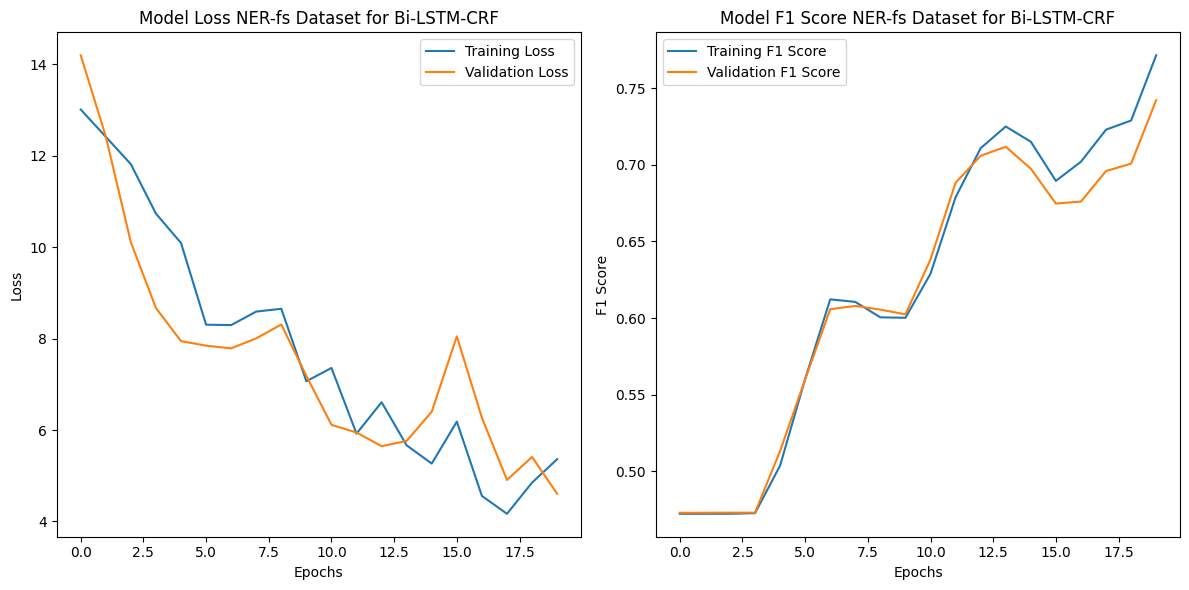

In [27]:
f1_callback = F1ScoreCallbackTrain(train_x_vec, train_y, val_x_vec, val_y,"fs-BLC-ATE.h5")

history = model.fit(data_generator(train_x_vec,train_y,32),
                        steps_per_epoch=len(train_x_vec) // 32,
                        epochs= 20,
                        validation_data=data_generator(val_x_vec,val_y,32),
                        validation_steps=len(val_x_vec) // 32,
                        callbacks=[f1_callback])
plot_metrics(history, 'NER-fs', 'Bi-LSTM-CRF')

# Test Script

In [17]:
from sklearn.metrics import accuracy_score, f1_score

def print_stats(model,title,full=False):
    test_predict = model.predict(data_generatorx(test_x_vec,32),steps=int(np.ceil(len(test_x_vec) / 32)),verbose=0)[0]
    test_f1 = f1_score(np.array(text_y).flatten(), test_predict.flatten(), average=None)
    test_acc = accuracy_score(np.array(text_y).flatten(), test_predict.flatten())
    lb = label_encoder.inverse_transform(np.argsort(test_f1))
    test_f1 = np.sort(test_f1)
    print("--------------------------------------------------------------------------------")
    # We dont consider the pad tokens
    print(f"Overal Test Results for {title}: Accuracy: {test_acc*100:.2f} % F1: {np.mean(test_f1[:-1]):.4f}")
    print("--------------------------------------------------------------------------------")
    if(full):
        for i in range(len(test_f1)):
            print("F1_macro for",lb[i],' '*(15-len(lb[i])),':',f"{test_f1[i]:.4f}")


In [18]:
model.load_weights("mod/gl-BLC.h5")

In [19]:

print_stats(model,"gl-BLC ATE",True)

--------------------------------------------------------------------------------
Overal Test Results for gl-BLC ATE: Accuracy: 98.04 % F1: 0.6487
--------------------------------------------------------------------------------
F1_macro for B_RESPONDENT     : 0.1600
F1_macro for I_RESPONDENT     : 0.1818
F1_macro for I_GPE            : 0.3733
F1_macro for B_PETITIONER     : 0.4000
F1_macro for B_ORG            : 0.4206
F1_macro for B_JUDGE          : 0.4286
F1_macro for I_ORG            : 0.4770
F1_macro for B_OTHER_PERSON   : 0.4921
F1_macro for I_PETITIONER     : 0.5000
F1_macro for B_WITNESS        : 0.5333
F1_macro for I_OTHER_PERSON   : 0.5603
F1_macro for I_JUDGE          : 0.5714
F1_macro for B_GPE            : 0.5752
F1_macro for I_WITNESS        : 0.6379
F1_macro for B_CASE_NUMBER    : 0.6385
F1_macro for I_CASE_NUMBER    : 0.7765
F1_macro for B_PRECEDENT      : 0.8000
F1_macro for B_STATUTE        : 0.8196
F1_macro for I_STATUTE        : 0.8512
F1_macro for I_COURT          : 